## Creating own dataset from Google Images

Inspired by Adrian Rosebrock and fast.ai


In [0]:
from fastai.vision import *

### Get a list of URLs

Go to Google Images and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

"canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press CtrlShiftJ in Windows/Linux and CmdOptJ in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

### Create directory and upload urls file into your server

Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.

In [0]:
folder = 'musk'
file = 'download'

In [0]:
folder = 'jobs'
file = 'download (1)'


In [0]:
path = Path('person')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [8]:
path.ls()

[PosixPath('person/musk'), PosixPath('person/jobs')]

### Download images:

Now you will need to download your images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename as well as the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

You will need to run this line once for every category.

In [0]:
classes = ['musk', 'jobs']

In [0]:
# download elon musk images
download_images(path/folder/file, dest, max_pics=200)

In [0]:
# download steve jobs images
download_images(path/folder/file, dest, max_pics=200)

Then we can remove any images that can't be opened:

In [0]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

### View data:

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [17]:
data.classes

['jobs', 'musk']

Lets see some pics

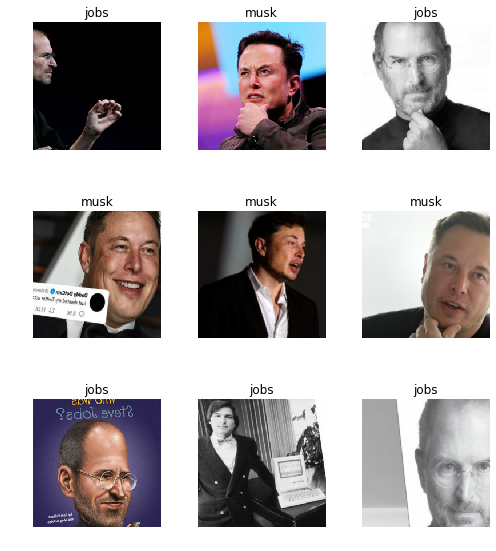

In [30]:

data.show_batch(rows=3, figsize=(7,8))

In [19]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['jobs', 'musk'], 2, 305, 76)

### Train model:

In [20]:
learn = cnn_learner(data, models.resnet34, metrics = error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 76880422.90it/s]


In [37]:
# fit_one_cycle will launch a training cycle using 1cycle policy to help you train your model faster
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.209758,0.192764,0.092105,00:04
1,0.182131,0.112173,0.026316,00:05
2,0.152737,0.062689,0.013158,00:05
3,0.120936,0.042624,0.013158,00:05


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [40]:
# lr_find() helps to select a good learning_rate.
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


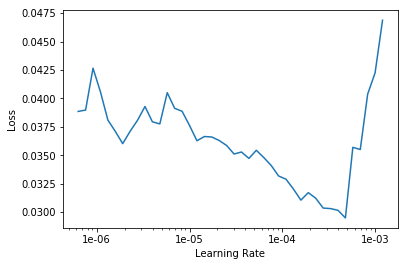

In [41]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))                                                                                                                                               

epoch,train_loss,valid_loss,error_rate,time
0,0.041305,0.047589,0.013158,00:04
1,0.037125,0.071482,0.026316,00:05


In [0]:
learn.save('stage-2')

### Interpretation :

In [44]:

learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (305 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
musk,musk,musk,musk,musk
Path: person;

Valid: LabelList (76 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
jobs,jobs,musk,musk,musk
Path: person;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (r

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

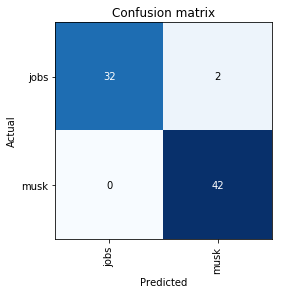

In [46]:
interp.plot_confusion_matrix()

### Putting your model in production:

In [0]:

learn.export()

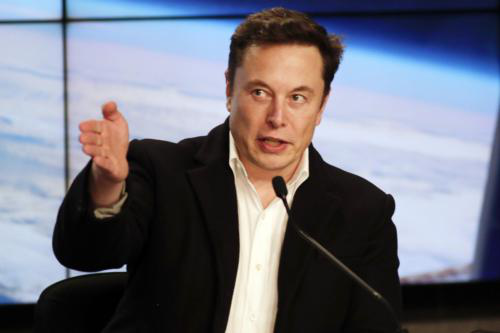

In [49]:
img = open_image(path/'musk'/'00000021.JPG')
img


We create our Learner in production enviromnent like this, just make sure that path contains the file 'export.pkl' from before.

In [0]:
learn = load_learner(path)

In [51]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

Category musk